
# CP322 — Assignment 2: Fake vs Real News Classification

**Dataset:** Fake and Real News — Kaggle  
**Goal:** Build classifiers (Naive Bayes, Logistic Regression, MLP) to detect fake news from text.  
**Student:** Jay Patel


In [56]:
import sys
print(sys.executable)

/usr/local/bin/python3.11


In [57]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [58]:
import nltk
print(nltk.__version__)

3.9.2


In [59]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [60]:
import torch
print(torch.__version__)

2.9.0


In [61]:
pip install numpy pandas matplotlib scikit-learn nltk torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


## 0) Setup & Imports

In [62]:
import os, random, re, string, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})

RANDOM_SEED = 19
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


## 1) Data Exploration & Preprocessing (5 pts)


### 1.1 Load & Merge
Load `True.csv` (label=0) and `Fake.csv` (label=1). Keep `title` and `text` only.

#### 1. Download the Fake/Real News dataset from Kaggle.
#### 2. Load both files and focus on the title and text columns, ignoring subject and date. Assign label=1 for fake news and label=0 for real news. Merge these into a single dataset.
#### 3. To demonstrate class imbalance, randomly undersample 20,000 real news and 1,000 fake news, and combine them into a new DataFrame. Use bar plot to show the distribution of labels after downsampling


In [63]:

FAKE_PATH = "Fake.csv"
REAL_PATH = "True.csv"

df_fake = pd.read_csv(FAKE_PATH, usecols=["title", "text"])
df_real = pd.read_csv(REAL_PATH, usecols=["title", "text"])
df_fake["label"] = 1  # fake -> 1
df_real["label"] = 0  # real -> 0

df_all = pd.concat([df_fake, df_real], ignore_index=True)
print("Full dataset shape:", df_all.shape)
df_all.head()


Full dataset shape: (44898, 3)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Mess...,Donald Trump just couldn t wish all Americans a Happy Ne...,1
1,Drunk Bragging Trump Staffer Started Russian Collusion ...,House Intelligence Committee Chairman Devin Nunes is goi...,1
2,Sheriff David Clarke Becomes An Internet Joke For Threa...,"On Friday, it was revealed that former Milwaukee Sheriff...",1
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Int...,"On Christmas day, Donald Trump announced that he would ...",1
4,Pope Francis Just Called Out Donald Trump During His Ch...,Pope Francis used his annual Christmas Day message to re...,1


### 1.2 Class Distribution & Missing Values

#### 1. Check for missing values (e.g., empty titles or text).
#### 2. Decide whether to drop or impute missing data based on the observation and give an explanation

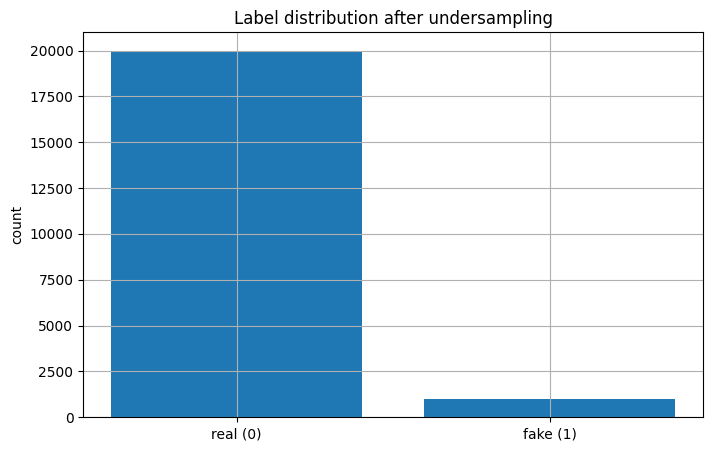

In [64]:


real_sample_n = min(20000, (df_all["label"] == 0).sum())
fake_sample_n = min(1000,  (df_all["label"] == 1).sum())

df_real_ds = df_all[df_all["label"] == 0].sample(real_sample_n, random_state=RANDOM_SEED)
df_fake_ds = df_all[df_all["label"] == 1].sample(fake_sample_n, random_state=RANDOM_SEED)

df_ds = pd.concat([df_real_ds, df_fake_ds], ignore_index=True).sample(
    frac=1, random_state=RANDOM_SEED
).reset_index(drop=True)


vc = df_ds["label"].value_counts().sort_index()
plt.bar(["real (0)", "fake (1)"], vc.values)
plt.title("Label distribution after undersampling")
plt.ylabel("count")
plt.show()


### 1.3 Text Preprocessing (tokenize, lowercase, stopwords, lemmatize)

#### 1. Tokenize the text.

#### 2. Remove stopwords (English).
#### 3. Lemmatize with WordNetLemmatizer()
#### 4. Convert text to lowercase.
#### 5. Show the top-5 rows of the DataFrame

In [65]:
# --- 1.3: build text_clean if missing + compact preview ---

# pick dataframe
_base = globals().get("df_ds", None)
if _base is None:
    _base = globals().get("df", None)

# create text_clean (regex tokenizer) if not present
if "text_clean" not in _base.columns:
    import re, string
    def _normalize(s: str) -> str:
        s = s.lower()
        s = s.translate(str.maketrans("", "", string.punctuation))
        return " ".join(re.findall(r"[a-z]+", s))
    _base["text_raw"] = (_base["title"].fillna("") + " " + _base["text"].fillna("")).astype(str)
    _base["text_clean"] = _base["text_raw"].apply(_normalize)

# compact preview
pd.set_option("display.max_colwidth", 60)
def fw(s: pd.Series, k: int) -> pd.Series:
    s = s.fillna("")
    parts = s.str.split()
    head = parts.str[:k].str.join(" ")
    return head.where(parts.str.len() <= k, head + " …")

preview = (
    _base[["label","title","text_clean"]]
      .assign(title=lambda d: fw(d["title"], 12),
              text_clean=lambda d: fw(d["text_clean"], 20))
      .head(5)
)

try:
    from IPython.display import display
    display(preview)
except:
    print(preview.to_string(index=False))


,label,title,text_clean
0,0,U.S.-backed Syria forces say Turkey pressured commander ...,usbacked syria forces say turkey pressured commander int...
1,0,Ireland says wants 'agreed wording' on Brexit border bef...,ireland says wants agreed wording on brexit border befor...
2,0,Obama wins over Cubans with straight talk and humility,obama wins over cubans with straight talk and humility h...
3,0,"Trump warns of riots, pulls plug on Republican president...",trump warns of riots pulls plug on republican presidenti...
4,0,Exclusive: India pares back planned funding for crucial ...,exclusive india pares back planned funding for crucial p...


## 2) Feature Engineering (1 pt)

#### 1. Bag-of-Words / TF-IDF Representation
##### • Convert the processed text into numeric features using scikit-learn’s TfidfVectorizer.
##### • Set parameters, such as ngram range of using unigram and max features=5000, etc.

#### 2. Split into Training and Test Sets
##### • Use an 80/20 split for training and test.
##### • Keep in mind the class imbalance and apply stratified sampling

In [66]:

_base = df if 'df' in locals() else (df_ds if 'df_ds' in locals() else None)
assert _base is not None and {"text_clean","label"}.issubset(_base.columns)

tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=5000)
X = tfidf.fit_transform(_base["text_clean"])
y = _base["label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=19
)
print("TF-IDF shape:", X.shape, "| Train/Test:", X_train.shape, X_test.shape)


TF-IDF shape: (21000, 5000) | Train/Test: (16800, 5000) (4200, 5000)


## 3) Naive Bayes & Logistic Regression (2 pts)

#### 1. Naive Bayesian
##### • Train a GaussianNB classifier on the vectorized data.
#### 2. Logistic Regression
##### • Train a logistic regression classifier on the vectorized data. Use max iter=100 to allow the model to converge

In [67]:
# --- 3.1 GaussianNB (needs dense) & 3.2 Logistic Regression (sparse OK) ---

# GaussianNB on dense arrays
X_train_gnb = X_train.toarray().astype(np.float32)
X_test_gnb  = X_test.toarray().astype(np.float32)

gnb = GaussianNB()
gnb.fit(X_train_gnb, y_train)
y_pred_gnb  = gnb.predict(X_test_gnb)
y_proba_gnb = gnb.predict_proba(X_test_gnb)[:, 1]

# Logistic Regression (works with sparse directly)
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train, y_train)
y_pred_lr  = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]



## 4) Multilayer Perceptron (PyTorch) (2 pts)


####  1. Neural Network Architecture
##### • The network should have two hidden layers, each with 128 units, using ReLU activations after the linear transfor- mations.
##### • The output layer should have one unit with a sigmoid activation so that the model produces probabilities between 0 and 1.
#### 2. Training and optimization
##### • Use binary cross-entropy loss (nn.BCELoss) and optimize with Adam at a learning rate of 0.001.
##### • Train the model for 20 epochs using the training data, making sure the input dimension matches the number of features in training data

In [68]:


Xtr_dense = torch.tensor(X_train.toarray(), dtype=torch.float32)
Xte_dense = torch.tensor(X_test.toarray(),  dtype=torch.float32)
ytr_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

input_dim = Xtr_dense.shape[1]

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),  
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_ds = TensorDataset(Xtr_dense, ytr_t)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

epochs = 20
model.train()
for ep in range(1, epochs + 1):
    total = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    print(f"Epoch {ep:02d} | loss = {total/len(train_ds):.4f}")

model.eval()
with torch.no_grad():
    proba_mlp = model(Xte_dense.to(device)).squeeze(1).cpu().numpy()
pred_mlp = (proba_mlp >= 0.5).astype(int)



Epoch 01 | loss = 0.2912
Epoch 02 | loss = 0.1065
Epoch 03 | loss = 0.0583
Epoch 04 | loss = 0.0233
Epoch 05 | loss = 0.0071
Epoch 06 | loss = 0.0031
Epoch 07 | loss = 0.0015
Epoch 08 | loss = 0.0006
Epoch 09 | loss = 0.0003
Epoch 10 | loss = 0.0002
Epoch 11 | loss = 0.0001
Epoch 12 | loss = 0.0001
Epoch 13 | loss = 0.0000
Epoch 14 | loss = 0.0000
Epoch 15 | loss = 0.0000
Epoch 16 | loss = 0.0000
Epoch 17 | loss = 0.0000
Epoch 18 | loss = 0.0000
Epoch 19 | loss = 0.0000
Epoch 20 | loss = 0.0000


## 5) Evaluation (5 pts)

### 5.1 Metrics

##### • Report above three models’ evaluation metrics including accuracy, precision, recall, F1-score, and AUC-ROC

In [69]:

def report_metrics(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    print(f"[{name}]  Acc={acc:.4f}  Prec={pre:.4f}  Rec={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    return acc, pre, rec, f1, auc

m_gnb = report_metrics(y_test, y_pred_gnb, y_proba_gnb, "GaussianNB")
m_lr  = report_metrics(y_test, y_pred_lr,  y_proba_lr,  "LogisticRegression")


[GaussianNB]  Acc=0.8895  Prec=0.2462  Rec=0.6400  F1=0.3556  AUC=0.7753
[LogisticRegression]  Acc=0.9795  Prec=0.9750  Rec=0.5850  F1=0.7312  AUC=0.9954


### 5.2 Confusion Matricies

##### • Plot the confusion matrix for all three methods.
##### • Interpret false positives and false negatives for this imbalanced dataset.


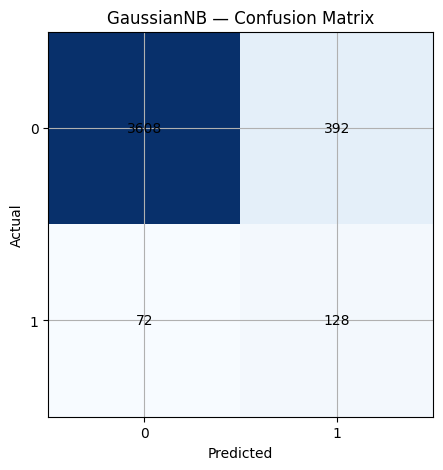

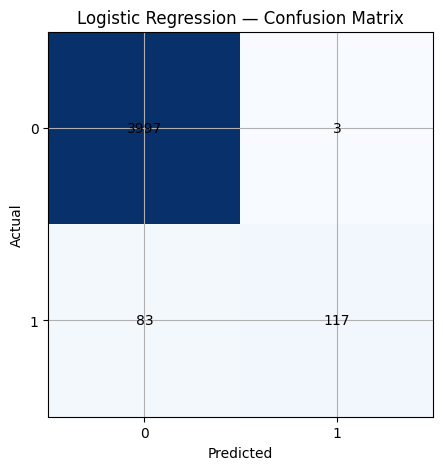

In [70]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha='center', va='center')
    plt.show()

plot_cm(y_test, y_pred_gnb, "GaussianNB — Confusion Matrix")
plot_cm(y_test, y_pred_lr,  "Logistic Regression — Confusion Matrix")


### 5.3 ROC curves

##### • Draw ROC curves of three models in a single plot.

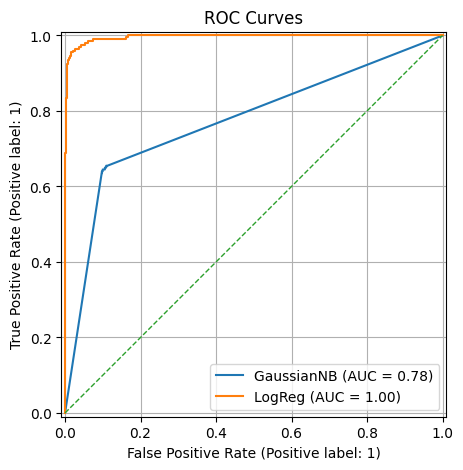

In [71]:

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_gnb, name="GaussianNB", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr,  name="LogReg",     ax=ax)
ax.plot([0,1],[0,1],'--', linewidth=1)
ax.set_title("ROC Curves")
plt.show()
